<a href="https://colab.research.google.com/github/dbwilburn/BIOC5721/blob/main/Gas_Law_Simulation_in_Python_wExplanation_AU24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dbwilburn/BIOC5721/blob/main/Gas_Law_Simulation_in_Python_AU24_code_explanation.ipynb)

# **BIOC5721 - Physical Biochemistry I**
DBW/RME 2024-08-15

To make best use of this notebook, Edit > Clear all outputs, then run desired cells sequentially

For example, this is a **markdown cell** where information can be written and formatted in various ways using different flags. They are useful for embedding different types of important textual data to accompany your source code.

Text can be **bolded**, _italicized_, and formatted to look like `code`, rendered as a $\frac{Latex}{equation}$, as well as other options. You can double click on this cell to see formatting procedures.

Install the required packages; for docs for details

Numpy: https://numpy.org/doc/
<br>
Pandas: https://pandas.pydata.org/docs/
<br>
Scipy: https://docs.scipy.org/doc/scipy/
<br>
Matplotlib: https://matplotlib.org/stable/index.html
<br>

*If already installed, can comment out the next line, or just not run the cell*

In [1]:
# comment out a code line by adding # at the beginning

In [2]:
!pip install numpy pandas scipy matplotlib

Next we will import the required libraries for data analysis. *A **Python Library** is a collection of source code that makes everyday tasks more efficient.* The four libraries that we are importing (`numpy`, `pandas`, `scipy`, and `matplotlib`) are the foundation of most modern Python informatics pipelines.

For the Python (iPython) interpretor that is connected to our Jupyter notebook to have access to the source code in the library, we need to `import` the library. Once the library is imported, we can access functions within the library by using `.` as a separator:

In [3]:
import numpy

numpy.mean([3,6])

4.5

For many commonly used libraries that will be called several times when writing a script, it is often useful to import libraries with **nicknames**. By using the  `import X as Y`  structure, we can give nicknames to libraries that can make things quicker to type.


Sometimes we may know we only want 1-2 functions out of a library, and also a means to minimize/simplify code later, we can selectively import those functions from libraries by using the structure  `from library.sub_library import function`

In [4]:
## Numpy and Pandas for numerical operations and data frames, respectively
import numpy as np, pandas as pd

## Matplotlib for data visualization
import matplotlib.pyplot as plt

## Import curve fit and stats sublibrary from scipy
import scipy.stats as stats # General statistics package

# In this script, we will make a **particle similator** to better understand the behavior of gas molecules in an isolated system (A box). You will be able to change the number of particles in the box, the mass of the particles, the size of the box, the average velocity of the particles, and the timestep of the simulation. You will see how these variables effect the pressure and temperature inside the box.





To start, we will make a **particle class** in python. In Python, a **class** is a blueprint or template for creating objects. An object is a specific instance of a class that contains both data (attributes) and functions (methods) that operate on that data.

For our purposes, consider a particle floating in space. The particle has three key properties: where it is right now (its position), how fast and in which direction it's moving (its velocity), and how heavy it is (its mass).

This Particle class is like a set of instructions for creating and controlling these particles. When you make a new Particle, you tell it where to start (its initial position), how fast it should be moving (its initial velocity), and how heavy it is (its mass).

Here's what each part of the Particle class does:

**Initialization** (__init__ method): When you create a new particle, you give it a starting position and velocity. The class stores these as the ball's current position and velocity. If you don’t specify how heavy the ball is, it will assume it weighs 1.0.

**Movement** (move method): This part of the class allows the ball to move. It updates the ball's position based on how fast it's moving. The ball moves in a straight line unless something stops it.

**Collision with walls** (collide_with_wall method): This part checks if the ball hits a wall. If the ball hits a wall, it bounces back, and its direction changes. This simulates the ball hitting a boundary and reflects its velocity, meaning it turns around and goes the opposite way. It also ensures the ball stays within the box's boundaries.

In [5]:
class Particle:
    def __init__(self, position, velocity, mass):
        self.position = np.array(position, dtype=float)
        self.velocity = np.array(velocity, dtype=float)
        self.mass = mass

    def move(self, dt):
        # Update position based on velocity
        self.position += self.velocity * dt


    def collide_with_wall(self, box_size):
        # Check for collisions with walls and reflect velocity
        collision = 0.0
        for i in range(len(self.position)):
            if self.position[i] <= 0 or self.position[i] >= box_size[i]:
                self.velocity[i] *= -1
                collision += np.abs(self.velocity[i]) * 2
                self.position[i] = np.clip(self.position[i], 0, box_size[i])
        return collision

Next we will create a **Particle_Simulator class**. This will allow us to simulate a container (box) to hold the particles, each of which can move and interact with the walls of the box. We will model the pressure and temperature within the box using this class.

Here's what each part of the box class does:
**__init__**: The constructor method initializes the box with its size, the number of particles inside of it (with random positions and velocities), and sets the initial pressure and temperature to zero.

 **update**: This method simulates what happens in the box during a small time interval (dt). Within this method, we:


1.   Reset Pressure: The pressure is reset at the beginning of each time step.
2.   Move Particles: Each particle is moved according to its velocity.
3. Calculate Kinetic Energy: For each particle, the kinetic energy is calculated based on its velocity and mass.
4. Update Pressure: The pressure is updated based on the collisions of particles with the walls. The more collisions, the higher the pressure.
5. Update Temperature: The temperature is calculated based on the total kinetic energy of all particles. It’s proportional to the average kinetic energy per particle.

**simulate**: This method runs the simulation over a defined length of time (final_time) in small time interval (dt) for some total number of steps (final_time/dt):

1. Record Data: It stores the positions of the particles, as well as the temperature and pressure of the box, at each step.
1. Return Results: After the simulation, it returns the time steps sampled, recorded positions of the particles over time, the temperatures, and the pressures

In [6]:
class Particle_Simulator:
    def __init__(self, size, n_particles, velocity_scalar=1.0, mass=1.0):
        self.size = np.array(size, dtype=float)
        self.n_dim = len(self.size)
        if self.n_dim <= 2:
            self.area = 2*np.sum(self.size)
        elif self.n_dim == 3:
            self.area = 2*np.sum(self.size*np.roll(self.size,1))

        self.particles = [Particle(position=np.random.rand(self.n_dim) * size,
                                   velocity=np.random.normal(loc=0, scale=velocity_scalar, size=self.n_dim),
                                   mass=mass)
                          for _ in range(n_particles)] # Randomly initialize starting positions and velocities
        self.pressure = 0
        self.temperature = 0

    def update(self, dt):
        # Reset pressure for this time step
        self.pressure = 0
        total_kinetic_energy = 0

        for particle in self.particles:
            particle.move(dt)

            # Calculate kinetic energy: 1/2 * m * v^2
            kinetic_energy = 0.5 * particle.mass * np.sum(particle.velocity ** 2)
            total_kinetic_energy += kinetic_energy / 1.5

            # Calculate pressure contribution from wall collisions
            self.pressure += particle.collide_with_wall(self.size) / dt / self.area

        # Calculate temperature as proportional to average kinetic energy
        #self.temperature = total_kinetic_energy / (len(self.particles) * 1.5)
        self.temperature = total_kinetic_energy

    def simulate(self, final_time, dt=0.01, verbose=True):
        # Prepare storage for positions, temperatures, and pressures
        positions_over_time = [[] for _ in range(len(self.particles))]
        temperatures = []
        pressures = []
        times = np.arange(dt, final_time+dt, dt) # dt to time in steps of dt
        for t in times:
            self.update(dt)
            temperatures.append(self.temperature)
            pressures.append(self.pressure)

            for i, particle in enumerate(self.particles):
                positions_over_time[i].append(particle.position.copy())
        if verbose:
            print('Simulation complete!')
        return times, positions_over_time, temperatures, pressures

Now that we have our classes defined, we are ready to run a simulation!

At the top of the next code block are the adjustable parameters:

1. **num_particles**: The number of particles in the simulation.
2. **box_size**: The dimensions of the 2D box.
3. **dt**: The time step for the simulation. It controls how much time advances with each update.
4. **total_time**: The total length of time the simulation will run and determines the duration of the simulation.
5. **velocity_scalar**: The standard deviation of the normal distribution used to randomly generate the velocities of the particles. It controls the speed of the particles.
6. **mass**: The mass of each particle.

Once the initial parameters are set, we create our **Particle_Simulator object** which will have **num_particles** that are initialized with random positions and velocities.

Finally, we **simulate** the behavior of each particle in the box over the specitied number of steps, with each step advancing by 'dt' units of time. As the simulation runs, we store the positions of the particles, the pressure, and the temperature of the box at each timestep.

In [7]:
# Adjustable arameters
num_particles = 500
box_size = [10, 10]
velocity_scalar = 25
mass = 1.0
simulation_time = 10.0
dt = 0.01

# Create and run the simulation
sim = Particle_Simulator(box_size, num_particles, velocity_scalar=velocity_scalar)

times, coordinates, temperatures, pressures = sim.simulate(simulation_time, dt=dt)


Simulation complete!


Now that we've run our simulation, let's look at how the temperature and pressure are changing overtime!

Mean temperature:  203158.51
Mean pressure:  2991.51


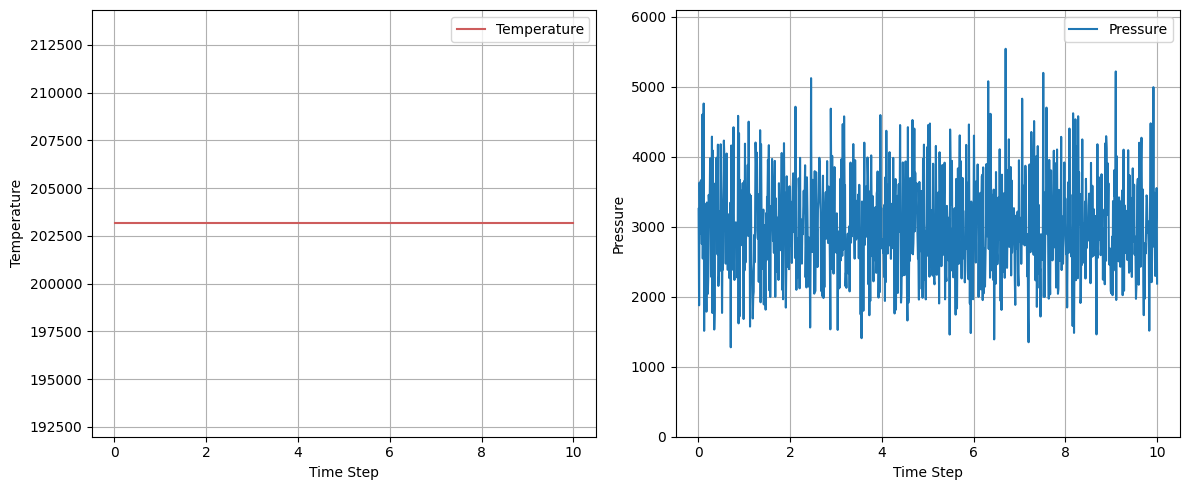

In [8]:
print('Mean temperature: ', str(round(np.mean(temperatures),2)))
print('Mean pressure: ', str(round(np.mean(pressures),2)))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plotting temperature
ax[0].plot(times, temperatures, label="Temperature", color = 'indianred')
ax[0].set_xlabel("Time Step")
ax[0].set_ylabel("Temperature")
ax[0].grid(True)
ax[0].legend()

# Plotting pressure
ax[1].plot(times, pressures, label="Pressure")
ax[1].set_ylim(0, max(pressures) + 0.1 * max(pressures))
ax[1].set_xlabel("Time Step")
ax[1].set_ylabel("Pressure")
ax[1].grid(True)
ax[1].legend()
fig.tight_layout()

It appears that the temperature is remaining constant over time. This result makes sense since our simulated box is effectivley an **isolated system** that does not exchange matter or energy with it's surroundings, and we are estimating temperature based on the total kinetic energy of the particles.

The pressure is fluctuating over time. This is because we are calculating pressure based on the number of particle collisions with the side of the box at each time step. This measurement is stochastic because on the timescale of our measurements, the number of particle collisions varies. How do you think the pressure will change if we increase the timestep of the simulation? Let's see...

> Add blockquote



In [9]:
# Adjustable arameters
num_particles = 500
box_size = [10, 10]
velocity_scalar = 25
mass = 1.0
simulation_time = 10.0
dt = 1.0 # increase dt

# Create and run the simulation
sim = Particle_Simulator(box_size, num_particles, velocity_scalar=velocity_scalar)

times, coordinates, temperatures, pressures = sim.simulate(simulation_time, dt=dt)


Simulation complete!


Mean temperature:  213387.65
Mean pressure:  968.69


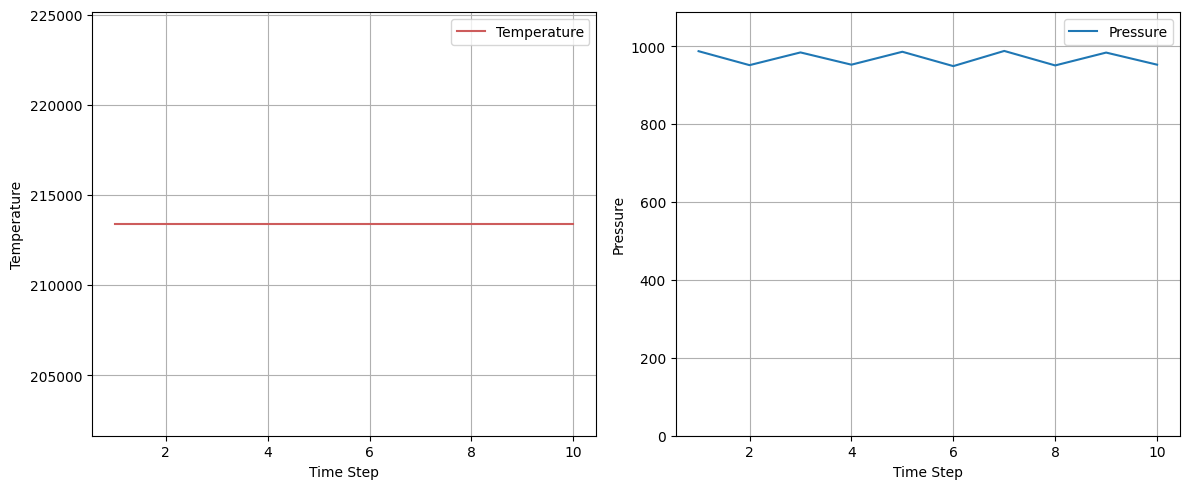

In [10]:
print('Mean temperature: ', str(round(np.mean(temperatures),2)))
print('Mean pressure: ', str(round(np.mean(pressures),2)))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plotting temperature
ax[0].plot(times, temperatures, label="Temperature", color = 'indianred')
ax[0].set_xlabel("Time Step")
ax[0].set_ylabel("Temperature")
ax[0].grid(True)
ax[0].legend()

# Plotting pressure
ax[1].plot(times, pressures, label="Pressure")
ax[1].set_ylim(0, max(pressures) + 0.1 * max(pressures))
ax[1].set_xlabel("Time Step")
ax[1].set_ylabel("Pressure")
ax[1].grid(True)
ax[1].legend()
fig.tight_layout()

Hmmm.. it looks like when we increase the timestep of our simulation, the pressure measurements stabalize over time, but why is this?

 At smaller timesteps, we observe significant fluctuations in pressure indicating that the simulation is capturing high-frequency, detailed interactions between particles and the wall. These fluctuations are more pronounced because the system is updating more frequently, revealing the rapid, **microscopic** changes in particle collisions.

With larger timesteps, the pressure measurement stabilizes as the simulation captures fewer fluctuations and averages out the rapid, micro-level variations. This leads to a smoother and more stable pressure profile over time, reflecting a more averaged, **macroscopic** view of the system’s behavior.

Let's rerun the simulation again at the smaller timestep to capture the microscopic behavior of the particles and visualize particle movement.

In [11]:
# Adjustable arameters
num_particles = 500
box_size = [10, 10]
velocity_scalar = 25
mass = 1.0
simulation_time = 10.0
dt = 0.01

# Create and run the simulation
sim = Particle_Simulator(box_size, num_particles, velocity_scalar=velocity_scalar)

times, coordinates, temperatures, pressures = sim.simulate(simulation_time, dt=dt)


Simulation complete!


Run the next block of code to plot the particles trajectory over time.

The path of 10 particles is shown in the background in gray. You can change the number of particle trajectories plotted in the background by adjusting the **num_particles_to_plot parameter**. You can change the transparency of these trajectories by adjusting the **alpha** value. The smaller alpha is, the more transparent the trajectories will be.

The trajectory of a single particle is shown in **red**. The displayed trajectory might be long or short depending on the initial velocity of the particle. Rerunning the simulation and replotting the this data will change the plotted trajectories.

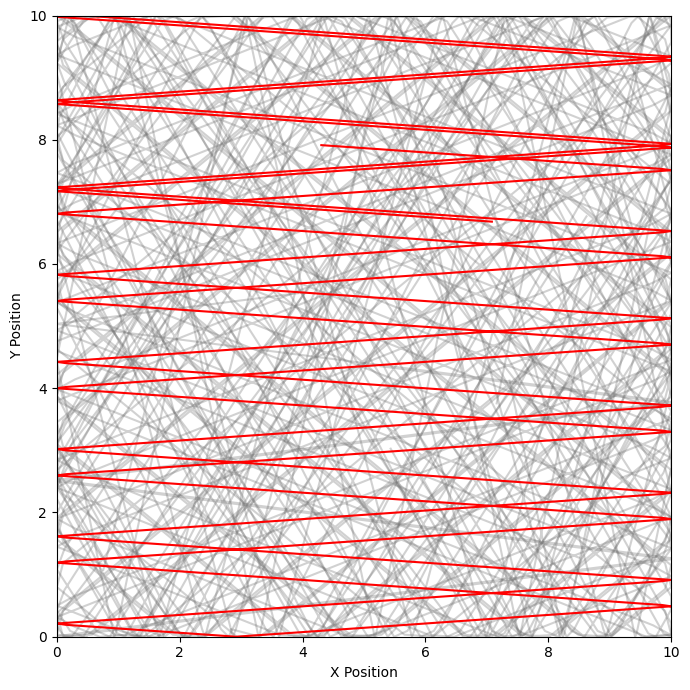

In [12]:
num_particles_to_plot = 10
alpha = 0.3
# Convert positions_over_time to a numpy array (time_steps, num_particles, 2)
trajectories = np.array(coordinates)

fig, ax = plt.subplots(figsize=(7, 7))

# Plot the next n particles in gray
for i in range(1, num_particles_to_plot):
    ax.plot(trajectories[i, :, 0], trajectories[i, :, 1], color='dimgray', alpha=alpha)

# Plot the first particle in red
ax.plot(trajectories[0, :, 0], trajectories[0, :, 1], color='red')

# Set limits and labels
ax.set_xlim(0, box_size[0])
ax.set_ylim(0, box_size[1])
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
fig.tight_layout()

Now, let's look at how changing different parameters effects the measured temperature and pressure overtime. We will change only the **velocity_scalar** parameter and plot the results.

In [13]:

velocity_scalars = [1, 2, 4, 16, 32, 64]
# Other parameters
num_particles = 500
box_size = [10, 10]
mass = 1.0
simulation_time = 10.0
dt = 0.01


avg_temps = []
avg_pressures = []

for velocity_scalar in velocity_scalars:
    # Create and run the simulation
    sim = Particle_Simulator(box_size, num_particles, velocity_scalar=velocity_scalar)
    times, coordinates, temperatures, pressures = sim.simulate(simulation_time, dt=dt)
    avg_temps.append(np.mean(temperatures))
    avg_pressures.append(np.mean(pressures))

Simulation complete!
Simulation complete!
Simulation complete!
Simulation complete!
Simulation complete!
Simulation complete!


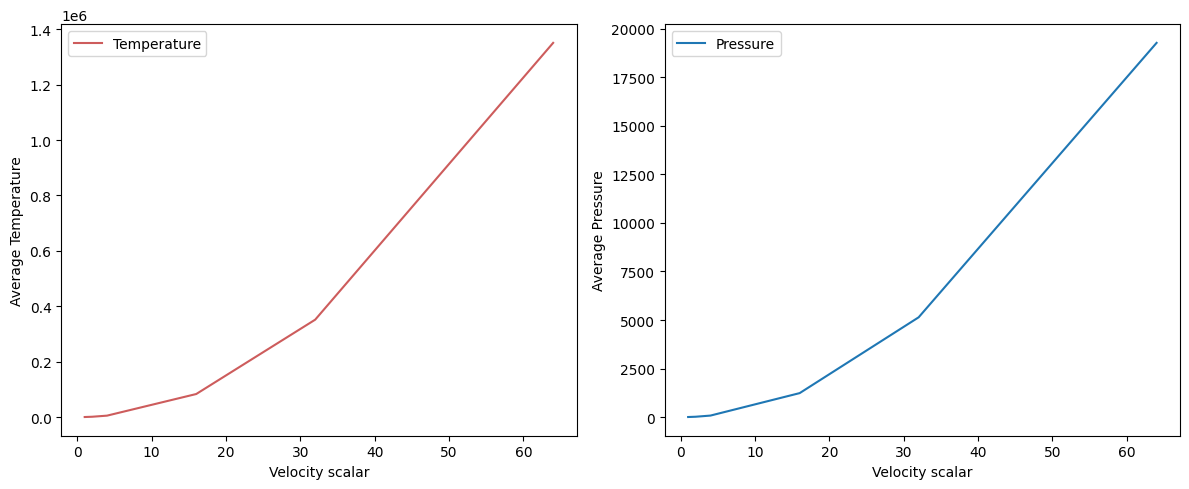

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plotting avg temperature
ax[0].plot(velocity_scalars, avg_temps, label="Temperature", color = 'indianred')
ax[0].set_xlabel("Velocity scalar")
ax[0].set_ylabel("Average Temperature")
ax[0].legend()

# Plotting avg pressure
ax[1].plot(velocity_scalars, avg_pressures, label="Pressure")
ax[1].set_xlabel("Velocity scalar")
ax[1].set_ylabel("Average Pressure")
ax[1].legend()
fig.tight_layout()

It appears that increasing the **velocity_scalar** parameter causes temperature and pressure to increase. Why might this make sense?

Let's see how increasing the number of particles in the simulation effects these parameters.

In [15]:


Num_particles = [10, 100, 250, 500, 750]
# Other parameters
box_size = [10, 10]
mass = 1.0
simulation_time = 10.0
dt = 0.01
velocity_scalar = 1.0


avg_temps = []
avg_pressures = []

for num_particles in Num_particles:
    # Create and run the simulation
    sim = Particle_Simulator(box_size, num_particles, velocity_scalar=velocity_scalar)
    times, coordinates, temperatures, pressures = sim.simulate(simulation_time, dt=dt)
    avg_temps.append(np.mean(temperatures))
    avg_pressures.append(np.mean(pressures))

Simulation complete!
Simulation complete!
Simulation complete!
Simulation complete!
Simulation complete!


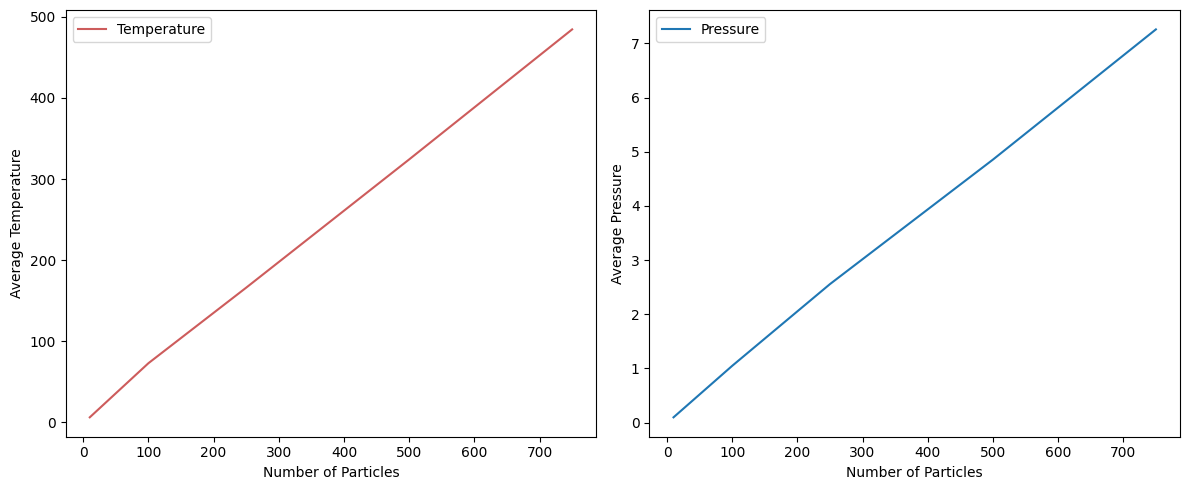

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plotting avg temperature
ax[0].plot(Num_particles, avg_temps, label="Temperature", color = 'indianred')
ax[0].set_xlabel("Number of Particles")
ax[0].set_ylabel("Average Temperature")
ax[0].legend()

# Plotting avg pressure
ax[1].plot(Num_particles, avg_pressures, label="Pressure")
ax[1].set_xlabel("Number of Particles")
ax[1].set_ylabel("Average Pressure")
ax[1].legend()
fig.tight_layout()

It appears that increasing the **num_particles** parameter causes temperature and pressure to increase linearly. Is there a common equation that explains this phenomenon?